# Content Analysis Script

**Please make a copy of this script if you want to run it yourself! Go 'File > Save A Copy In Drive'**

This is a work in progress version of a content analysis script, that I hope helps offer SEOs and digital marketers another datapoint to understand what their audience might want when they are searching for relevant keywords. Also, to help SEOs understand how the might be able to structure the content on their landing pages to give those pages the best chance of ranking.

 
This script was written to help me learn Python and to explore the many possibilities that exist to improve SEO workflows. It is therefore not likely to be particularly 'Pythonic'; however if anyone has any advice or recommendations please reach out to me at https://twitter.com/RoryT11

**IMPORTANT NOTE** - My recommendation is to ***download this script and run it locally*** rather than via Colabs as it can time out when scraping content across a number of URLs

# Step 1 - **Import Libraries**

The first step in cell 1 is to import the various libraries we will need to run our analysis:

In [74]:
import requests
!pip install requests[security]
import string
import urllib
import collections
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk import word_tokenize, pos_tag, pos_tag_sents
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
stop = stopwords.words('english')
%matplotlib inline
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
import itertools as it
import networkx as nx
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
! pip install pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline
import pyLDAvis.sklearn
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import time
from time import sleep
#headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Step 2 - **Create 'Google URLs' for keywords and scrape**

The second step in this process is to create a list of 'Google URLs' for each of our keywords. This cell will then execute a process to scrape the 'Google URLs' we have created and extract the ranking URL, ranking page title and ranking meta descriptions for those queries.

There are a number of elements in this cell you may wish to change:


1.   **queries** >> Enter a list of keywords you want to analyse in speech marks and comma separated
1.   **base_url** >> Currently set to google.co.uk, but you may wish to change to the relevant Google ccTLD for your own analysis
2.   **num** >> This is the number of results you want for the SERP. Currently set to '10'
3.   **serp_country** >> This is the country that you want to analyse results from. ***PLEASE NOTE -***  when running this script in Google Colabs it will always give you results as if you are searching from the US. I am unsure how to change this, but if there are any suggestions please reach out!

In [0]:
base_url = "https://www.google.co.uk/search"
queries = ["end of tenancy cleaning london"]
serp_queries = []
serp_urls = []
clean_links = []
links = []
serp_titles = []
serp_descriptions = []

for q in queries:
    query = urllib.parse.quote_plus(q)
    serp_queries.append(query)

for q in serp_queries:
    url = "{base_url}?q={query}&num={num}&cr={serp_country}".format(base_url=base_url, query=q, num="10", serp_country="GB")
    serp_urls.append(url)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    result_div = soup.find_all('div', attrs = {'class': 'ZINbbc'})
    for r in result_div:
        # Checks if each element is present, else, raise exception
        try:
            link = r.find('a', href = True)
            title = r.find('div', attrs={'class':'vvjwJb'}).get_text()
            description = r.find('div', attrs={'class':'s3v9rd'}).get_text()
            # Check to make sure everything is present before appending
            if link != '' and title != '' and description != '': 
                links.append(link['href'])
                serp_titles.append(title)
                serp_descriptions.append(description)
        # Next loop if one element is not present
        except:
            continue
    to_remove = []
    for i, l in enumerate(links):
        clean = re.search('\/url\?q\=(.*)\&sa',l)

        # Anything that doesn't fit the above pattern will be removed
        if clean is None:
            to_remove.append(i)
            continue
        clean_links.append(clean.group(1))
        #print(clean_links)

dedupe_clean_links = list(dict.fromkeys(clean_links))

# Step 3 - **Scrape Content from Top Ranking Pages**

The third step does a couple of important things. First of all, it runs a crawler through each of the landing pages that are ranking in the SERPs for your target keywords (deduplicated in previous cell).

It will then scrape those page and extract all the copy in paragraph tags (which goes to the '**scraped_content**' dictionary), and it will scrape all the H1, H2, H3 and H4 tags (which goes to the '**scraped_titles**' dictionary).

The content in these two dictionaries is what will be analysed in the subsequent cells.

**NOTE** - Sometimes there are difficulties scraping this content if a site has bot protection etc. When this happens I will change my queries/count of results but if anyone has a better suggestion for mitigating this then please let me know!


In [0]:
paragraphs = []
titles = []
scraped_content = []
scraped_titles = []
for url in dedupe_clean_links:
        #time.sleep(0.01)
        response = requests.get(url, time.sleep(2)) #headers=headers
        soup2 = BeautifulSoup(response.content, "html.parser")
        paragraphs = soup2.find_all('p')
        titles = soup2.find_all(re.compile('^h[1-4]$'))
               
        for paragraph in paragraphs:
            paragraphs = [paragraph.text]
            paragraphs = paragraph.get_text()
            scraped_content.append(paragraphs)
        
        for title in titles:
            titles = [title.text]
            titles = title.get_text()
            scraped_titles.append(titles)
scraped_content = list(map(str.strip, scraped_content))
scraped_titles = list(map(str.strip, scraped_titles))

# Step 4 - **Part of Speech Analysis**

The next 5 cells run a 'Part of Speech' (PoS) co-occurrence analysis on our extracted paragraph copy. The aim of this is to identify trends in the most commonly occurring nouns, verbs, adjectives and adverbs that appear in ranking content.

The 5 cells below work through the following processes:


1.   Create a dataframe from our scraped content and tidy it (case consistent, remove puncutation, remove stop words) - it will then map PoS tags to each of the words in our dataframe, then create a new column with a count of those tags based on a function we have created.

2.   It will then create a vocabulary based on the words and their respective tags in our analysis and then use that mapping to build a clean dataframe that shows the most commonly occurring nouns, verbs etc. in our content.

3.   Cells 3, 4, 5 then create visuals based on those linguistic trends for nouns, verbs, adjectices and adverbs.

***Please note ***- the entire dataframe will be downloaded as an excel so you can explore fully.




In [0]:
def count_tags(input_tag):
    tag_count = {}
    for word, tag in input_tag:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return(tag_count)

df = pd.DataFrame.from_dict({'Serp_Content': scraped_content}).astype(str)
df['Serp_Content'] = df['Serp_Content'].fillna("").str.lower().str.replace('[^\w\s]','')
df['Serp_Content'] = df['Serp_Content'].apply(lambda x: [item for item in x.split() if item not in stop]).map(pos_tag)
df['Serp_Content_PoS_Counts'] = df['Serp_Content'].map(count_tags)
#df.head()

In [78]:
vocabulary = {}
for row in df['Serp_Content']:
    for word, tag in row:
        if word in vocabulary:
            if tag in vocabulary[word]:
                vocabulary[word][tag] += 1
            else:
                vocabulary[word][tag] = 1
        else:
            vocabulary[word] = {tag: 1}

vocabulary_df = pd.DataFrame.from_dict(vocabulary, orient='index')
vocabulary_df.fillna(value=0, inplace=True)

vocabulary_df.rename(columns = {'NN':'Noun'},inplace=True)
vocabulary_df.rename(columns = {'NNS':'Noun'},inplace=True)
vocabulary_df.rename(columns = {'NNP':'Noun'},inplace=True)
vocabulary_df.rename(columns = {'NNPS':'Noun'},inplace=True)
vocabulary_df.rename(columns = {'RB':'Adverb'},inplace=True)
vocabulary_df.rename(columns = {'RBR':'Adverb'},inplace=True)
vocabulary_df.rename(columns = {'RBS':'Adverb'},inplace=True)
vocabulary_df.rename(columns = {'VB':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBD':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBG':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBG':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBN':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBP':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'VBZ':'Verb'},inplace=True)
vocabulary_df.rename(columns = {'JJ':'Adjective'},inplace=True)
vocabulary_df.rename(columns = {'JJR':'Adjective'},inplace=True)
vocabulary_df.rename(columns = {'JJS':'Adjective'},inplace=True)

pos_list = ['Noun', 'Adverb', 'Verb', 'Adjective']

vocabulary_df = vocabulary_df[pos_list]
vocabulary_df = vocabulary_df.groupby(lambda x:x, axis=1).sum()
vocabulary_df = vocabulary_df.sort_values('Noun', ascending=False)

vocabulary_df.head()

,Adjective,Adverb,Noun,Verb
tenancy,0.0,0.0,98.0,0.0
cleaning,1.0,0.0,81.0,145.0
end,4.0,0.0,79.0,9.0
service,0.0,0.0,79.0,1.0
property,0.0,0.0,67.0,0.0


Text(0.5, 0, 'Count')

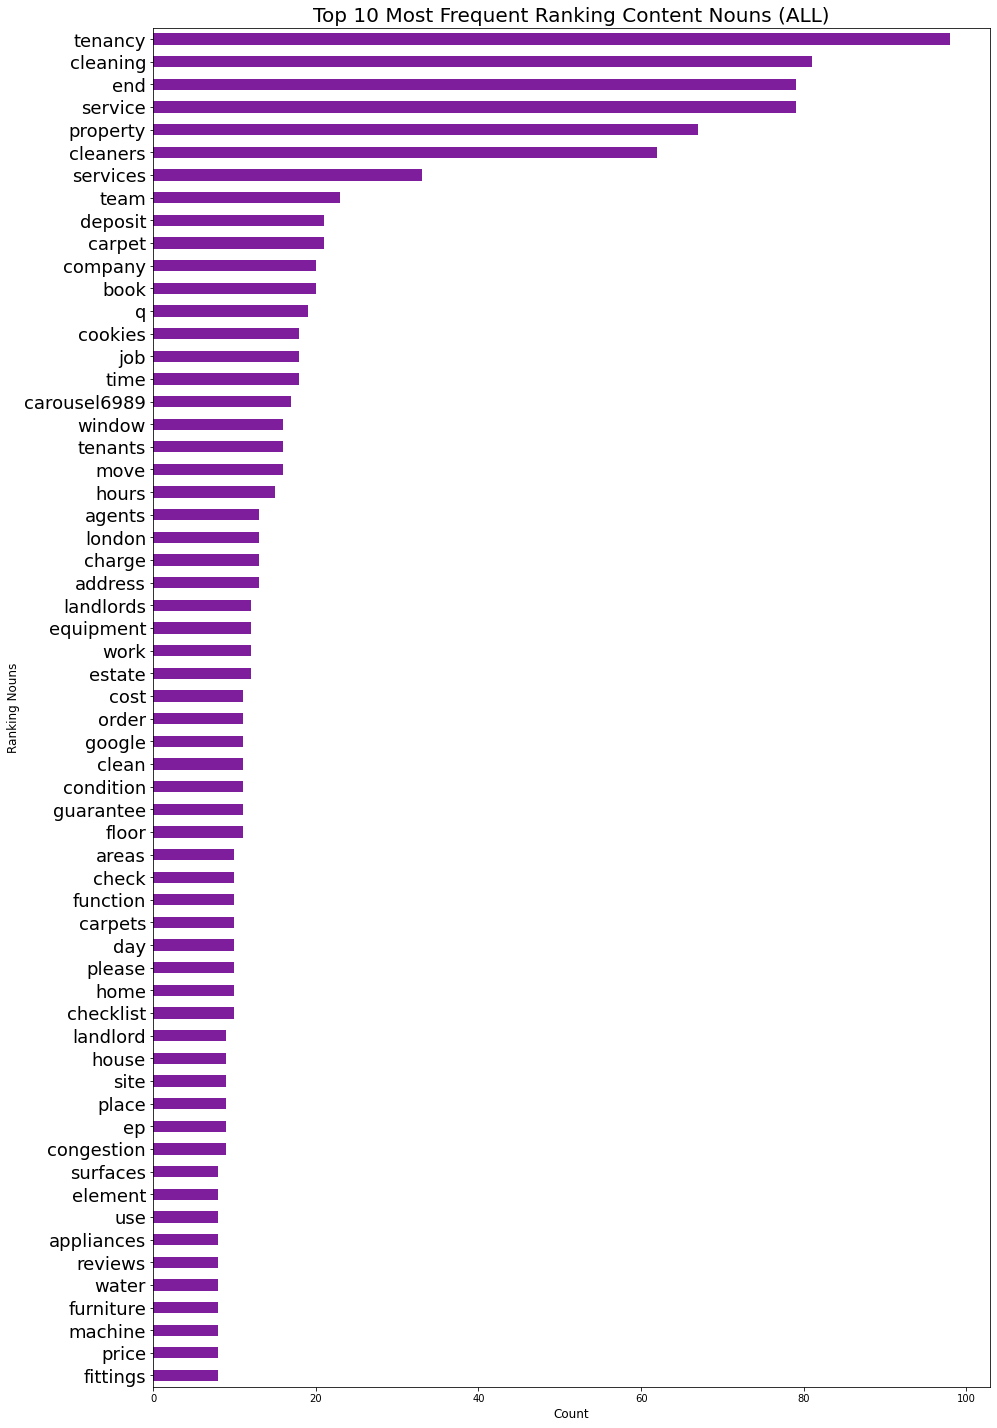

In [79]:
size4 = 60 # Change this number to how many words you want to show in your visual
tag4 = 'Noun' # Change this to the PoS tag that you want to analyse 
ax = vocabulary_df[tag4].sort_values().tail(size4).plot(kind='barh', figsize=(15,25), color='xkcd:purple')
ax.tick_params(axis="y", labelsize=18)
ax.set_title('Top 10 Most Frequent Ranking Content Nouns (ALL)', fontsize='20')
ax.set_ylabel('Ranking Nouns', fontsize='12')
ax.set_xlabel('Count', fontsize='12')
#ax.title.set_position([.5, 1.01])

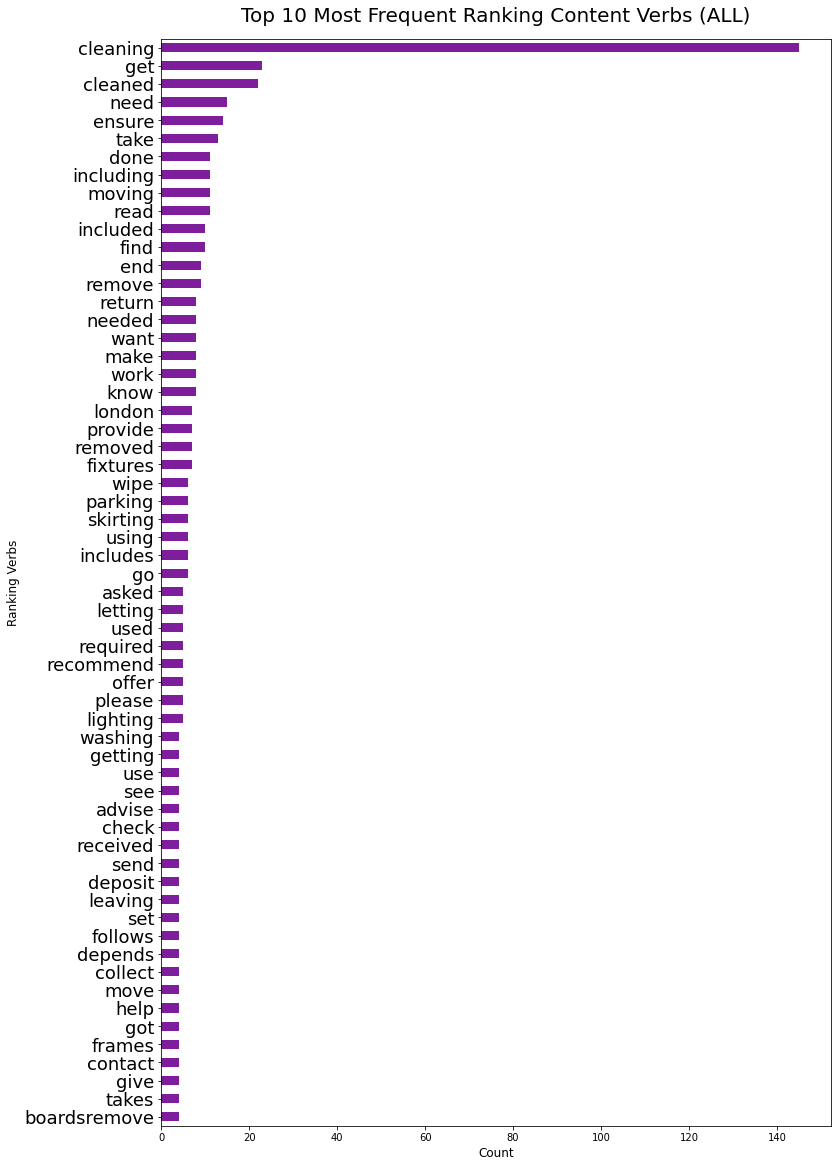

In [80]:
size5 = 60 # Change this number to how many words you want to show in your visual
tag5 = 'Verb' # Change this to the PoS tag that you want to analyse 
ax = vocabulary_df[tag5].sort_values().tail(size5).plot(kind='barh', figsize=(12,20), color='xkcd:purple')
ax.tick_params(axis="y", labelsize=18)
ax.set_title('Top 10 Most Frequent Ranking Content Verbs (ALL)', fontsize='20')
ax.set_ylabel('Ranking Verbs', fontsize='12')
ax.set_xlabel('Count', fontsize='12')
ax.title.set_position([.5, 1.01])

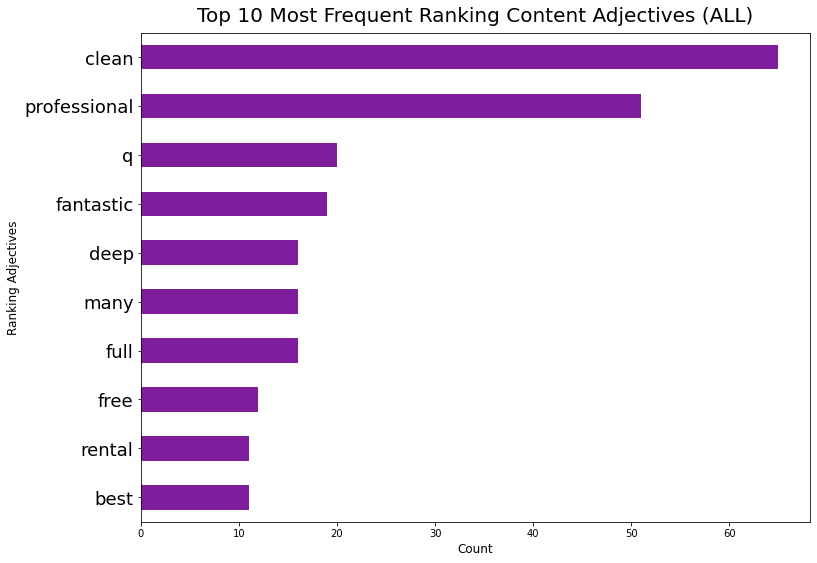

In [81]:
size6 = 10 # Change this number to how many words you want to show in your visual
tag6 = 'Adjective' # Change this to the PoS tag that you want to analyse 
ax = vocabulary_df[tag6].sort_values().tail(size6).plot(kind='barh', figsize=(12,9), color='xkcd:purple')
ax.tick_params(axis="y", labelsize=18)
ax.set_title('Top 10 Most Frequent Ranking Content Adjectives (ALL)', fontsize='20')
ax.set_ylabel('Ranking Adjectives', fontsize='12')
ax.set_xlabel('Count', fontsize='12')
ax.title.set_position([.5, 1.01])

# Step 5 - **Named Entity Extraction**

This process is similar to the one above and goes through similar processes, however the output is a dataframe containing a list of the most frequently occurring named entities within our ranking content.

[Spacy is used](https://spacy.io/usage/linguistic-features#named-entities) to extract the named entities and a glossary of the way it groups entities can be found here:

https://spacy.io/api/annotation#named-entities 

This can be particularly useful for spotting patterns in the organisations or people (for example) that feature regularly in top performing content. The consistent presence of these entities may help Google understand the topics that your landing page is relvant for (as well as contributing to topical authority), and can therefore become a useful reference point in how you target certain keywords with content across your site. 

In [82]:
scraped_content_2 = scraped_content.copy()
scraped_content_3 = ''.join(map(str, scraped_content_2))
scraped_content_3 = scraped_content_3.strip(string.punctuation)
scraped_content_3 = scraped_content_3.replace(",", " ").replace("[", " ").replace("]", " ").replace("\\", " ")
entities = nlp(scraped_content_3)
labels = [x.label_ for x in entities.ents]
entity_map = dict([(str(x), x.label_) for x in nlp(str(entities)).ents])

#entity_map
#displacy.render(nlp(str(entities)), jupyter=True, style='ent')

def count_entities(input_tag):
    tag_count = {}
    for word, tag in input_tag:
        if tag in tag_count:
            tag_count[tag] += 1
        else:
            tag_count[tag] = 1
    return(tag_count)

df2 = pd.DataFrame.from_dict({'Serp_Content': scraped_content})
df2['Serp_Content'] = df2['Serp_Content'].astype(str).str.replace('[^\w\s]','')
def spacy_entity(df):    
    df2 = nlp(df)
    df3 = [[w.text,w.label_] for w in df2.ents]
    return df3
df2['Serp_Content'] = df2['Serp_Content'].apply(spacy_entity)
df2['Entity_Counts'] = df2['Serp_Content'].map(count_entities)

ent_vocabulary = {}
for row in df2['Serp_Content']:
    for word, tag in row:
        if word in ent_vocabulary:
            if tag in ent_vocabulary[word]:
                ent_vocabulary[word][tag] += 1
            else:
                ent_vocabulary[word][tag] = 1
        else:
            ent_vocabulary[word] = {tag: 1}

ent_df = pd.DataFrame.from_dict(ent_vocabulary, orient='index')
ent_df.fillna(value=0, inplace=True)

ent_df.sort_values('GPE', ascending=False).head(10)

,GPE,DATE,CARDINAL,NORP,ORG,LOC,TIME,PRODUCT,LAW,FAC,PERSON,ORDINAL,QUANTITY
London,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
UK,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
heshe,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Booleanelementsindex\r\n\t\t\r\n\t\r\n\r\n\t,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LondonAll,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
US,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
West London,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Newcastle,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
the United Kingdom,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Youtube,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Text(0.5, 0, 'Count')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 13 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


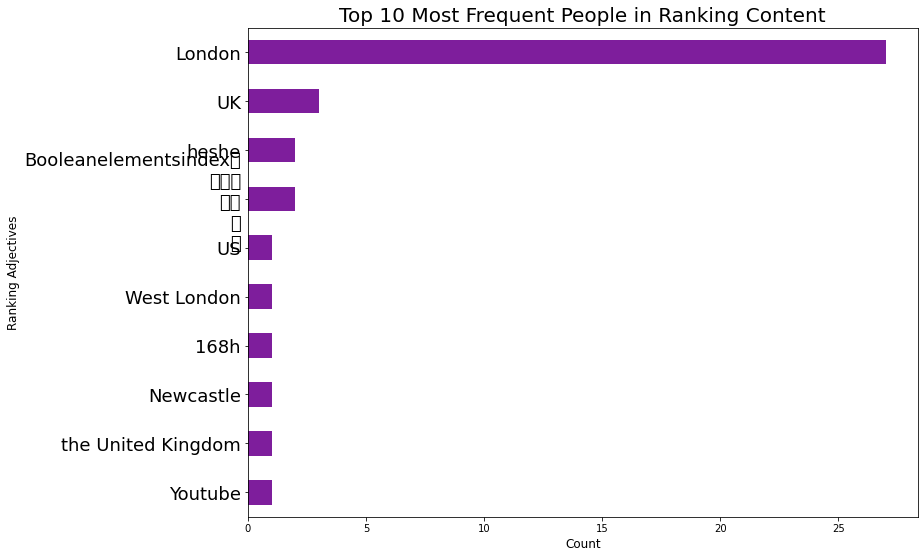

In [84]:
#Uncomment to get visuals similar to those above
size = 10 # Change this number to how many words you want to show in your visual
tag = 'GPE' # Change this to the PoS tag that you want to analyse 
ax = ent_df[tag].sort_values().tail(size).plot(kind='barh', figsize=(12,9), color='xkcd:purple')
ax.tick_params(axis="y", labelsize=18)
ax.set_title('Top 10 Most Frequent People in Ranking Content', fontsize='20')
ax.set_ylabel('Ranking Adjectives', fontsize='12')
ax.set_xlabel('Count', fontsize='12')

# Step 6 - **Topical Resonance Analysis**

The next analysis we can run our top ranking content is around 'topical resonance', which should ultimately help us understand how important certain words or phrases are to the topics we have specified in the keywords we are analysing.

It does this by utilising two libraries primarily - NLTK and NetworkX. It works by attempting to analyse compound noun phrases (created by only looking at sentences containing a noun and an adjective, then creating a list of those words) and building a network from nouns and adjectives that occur in the same sentence.

It will then use [betweenness_centrality](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.centrality.betweenness_centrality.html) to attempt to identify the most central words within that network (i.e. the **most important words**).

The output is a dataframe that contains a word and its resonance to the topics we are searching for.

The idea of this research is to help understand how importanct certain words or topics could be to the keyword we are searching for. This can help inform the content we create for the landing pages that we want to rank for that term (i.e. if a word is highly resonant, its use in on page content could help search engines better understand the relevance of that page and the keywords it should rank for).  



In [85]:
for token, tag in df.Serp_Content[0]:
    if re.match(r'NN*|JJ*', tag):
        print (token, tag)

noun_phrases = [[token for token, tag in sent if re.match(r'NN*|JJ*', tag)] 
                for sent in df.Serp_Content]
edgelist = [edge for phrase in noun_phrases for edge in it.combinations(phrase, 2)]

G = nx.Graph(edgelist)
index = nx.betweenness_centrality(G)
for component in list(nx.connected_components(G)):
    if len(component)<5:
        for node in component:
            G.remove_node(node)

sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)

# Top 20 noun phrases by betweenness centrality:
#for word, centr in sorted_index[:20]:
        #print (word, centr)

remove = [node for node,degree in dict(G.degree()).items() if degree < 2]

#%pylab inline
#%config InlineBackend.figure_format = 'png'
#plt.rc('figure', figsize=(24, 18))
#G.remove_nodes_from([n for n in index if index[n] == .0])
#G.remove_nodes_from(remove)
#node_size = [index[n]*20000 for n in G]
#pos = nx.spring_layout(G)
#nx.draw_networkx(G, pos, node_size=node_size, edge_color='Y', alpha=.8, linewidths=0, font_color='Black', font_size='10', font_weight='bold')

gofantastic JJ
app NN


In [86]:
resonance_df = pd.DataFrame(sorted_index, columns=['Word', 'Resonance'])

resonance_df.sort_values('Resonance', ascending=False).head()

,Word,Resonance
0,service,0.080115
1,cleaning,0.057698
2,tenancy,0.052860
3,professional,0.051043
4,cleaners,0.050047


# Step 7 - **Page Title N-Grams Analysis**

Pretty straightforward [analysis of N-Grams](https://blog.xrds.acm.org/2017/10/introduction-n-grams-need/) but only looking at the titles on the pages we have analysed.

The output is a dataframe with a list of the most frequently occurring two and three word phrases that appear in the header 1-4 tags on the pages we have analysed. 

It does this by creating a new dataframe containing the relevant H tags from the pages we have analysed and then building a counter to count how many times a combination of words appears.

The output of this analysis can help inform how you structre your page titles and the type of language that you include in that element of your landing pages.

In [89]:
scraped_titles_df = pd.DataFrame.from_dict({'Serp_Titles': scraped_titles}).astype(str)
scraped_titles_df['Serp_Titles'] = scraped_titles_df['Serp_Titles'].fillna("").str.lower().str.replace('[^\w\s]','').apply(lambda x: [item for item in x.split() if item not in stop])
scraped_titles_list = list(filter(None,scraped_titles_df.Serp_Titles.tolist()))
serp_titles_counts = collections.Counter(max_df = 0.99)

for phrase in scraped_titles_list:
    #serp_titles_counts.update(nltk.ngrams(phrase, 1))
    serp_titles_counts.update(nltk.ngrams(phrase, 4))
    serp_titles_counts.update(nltk.ngrams(phrase, 10))
serp_titles_trends=serp_titles_counts.most_common(90)

ranking_titles_trends=pd.DataFrame(serp_titles_trends, columns=["Titles", "Count"])

def remove_brackets(Titles):
    fixed_keyword=' '.join(Titles)
    return fixed_keyword

ranking_titles_trends['Titles'] = ranking_titles_trends.Titles.apply(remove_brackets)

ranking_titles_trends.head()

,Titles,Count
0,end tenancy cleaning london,10
1,end tenancy cleaning checklist,3
2,professional end tenancy cleaning,2
3,best end tenancy cleaning,2
4,comprehensive end tenancy cleaning,2


# Step 8 - **Topic Modelling**

The next workflow across the following 3 cells is all around [topic modelling](https://en.wikipedia.org/wiki/Topic_model) - in essence, using unservised learning to attempt to identify logical groups of topics in the content we are anlysing. This is going to be represented as a collection of words that can be seen in the dataframe below.

The method of topic modelling is [LDA](http://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) - and there are many other models that can be used for topic modelling. However, hopefully this process demonstrates how it works and potential use cases.

The output dataframe is in some ways not ideal as it does not 'label' the topical groupings - you have to look at them manually and 'translate' the output into something meaningful to the campaigns you are working on. 

However, it can be really useful for spotting trends and as a datapoint for content ideation (for example, you can create a content silo for each of the topics identified). It can also inform internal linking decisions (for example, focus on internal linking pages that would fit within one of your topical content groupings).

**NOTE** - there is an optional section in the third cell below where you can label your 'topic groupings' accordingly (see the label called 'Topics' below). This will come into play later in our script.


In [0]:
topics_df = pd.DataFrame.from_dict({'Serp_Content': scraped_content}).astype(str)
data = topics_df.Serp_Content.values.tolist()
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuation

data_words = list(sent_to_words(data))

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                         # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                             max_df = 0.95
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)
data_dense = data_vectorized.todense()

In [91]:
# Build LDA Model - can take a while!
lda_model = LatentDirichletAllocation(n_components=20,           # Number of topics
                                      max_iter=30,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30, 35, 40], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 10}


In [92]:
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=10):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
Topics = ["Topic Label 1","Topic Label 2","Topic Label 3","Topic Label 4","Topic Label 5", "Topic Label 6", "Topic Label 7", "Topic Label 8", "Topic Label 9", "Topic Label 10"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords.head()

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Topics
Topic 0,click,disable,service,enable,charge,membership,programme,term,policy,property,cleaner,day,price,away,privacy,Topic Label 1
Topic 1,clean,window,inside,wipe,switch,floor,include,remove,light,dust,skirting,appliance,address,frame,line,Topic Label 2
Topic 2,carpet,know,clean,service,cleaning,stain,fridge,arrive,freezer,work,time,team,remove,flat,read,Topic Label 3
Topic 3,job,clean,service,property,need,include,quote,area,cleaner,cleaning,blind,work,charge,deep,price,Topic Label 4
Topic 4,cleaning,clean,service,property,tenancy,professional,end,cleaner,company,deposit,good,book,hour,tenant,cost,Topic Label 5


# Step 9 - **PoS Analysis on SERP Content**

I was feeling lazy...so this analysis is pretty much identical to the PoS analysis conducted in 'Step 4' of this document. However, the big difference is that it runs this analysis on the content that appears in the SERPs for our target keywords rather than the landing pages themselves.

I have some spiel around why this kind of analysis can be important - https://www.slideshare.net/DistilledSEO/searchlove-london-2019-rory-truesdale-using-the-serps-to-know-your-audience

The main thing is that frequently Google is rewriting the content it displays in the SERPs based on what it thinks a user wants to see. Therefore analysing trends in this language can form a useful for point of research for how you structure your on page content.

In [94]:
serp_dict = pd.DataFrame.from_dict({'SERP_Titles': serp_titles, 'SERP_Descriptions': serp_descriptions}).astype(str).drop_duplicates(subset=['SERP_Titles'], keep=False)
serp_dict["SERP_Combination"] = serp_dict["SERP_Titles"].map(str) + serp_dict["SERP_Descriptions"]
serp_dict["SERP_Combination"] = serp_dict["SERP_Combination"].fillna("").str.lower().str.replace('[^\w\s]','').apply(lambda x: [item for item in x.split() if item not in stop]).map(pos_tag)
serp_dict["SERP_Combination_Counts"] = serp_dict["SERP_Combination"].map(count_tags)
serp_language_vocabulary = {}
for row in serp_dict["SERP_Combination"]:
    for word, tag in row:
        if word in serp_language_vocabulary:
            if tag in serp_language_vocabulary[word]:
                serp_language_vocabulary[word][tag] += 1
            else:
                serp_language_vocabulary[word][tag] = 1
        else:
            serp_language_vocabulary[word] = {tag: 1}

serp_language_vocabulary_df = pd.DataFrame.from_dict(serp_language_vocabulary, orient='index')
serp_language_vocabulary_df.fillna(value=0, inplace=True)
serp_language_vocabulary_df.rename(columns = {'NN':'Noun'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'NNS':'Noun'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'NNP':'Noun'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'NNPS':'Noun'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'RB':'Adverb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'RBR':'Adverb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'RBS':'Adverb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VB':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBD':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBG':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBG':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBN':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBP':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'VBZ':'Verb'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'JJ':'Adjective'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'JJR':'Adjective'},inplace=True)
serp_language_vocabulary_df.rename(columns = {'JJS':'Adjective'},inplace=True)
serp_language_vocabulary_df = serp_language_vocabulary_df[pos_list]
serp_language_vocabulary_df = serp_language_vocabulary_df.groupby(lambda x:x, axis=1).sum()
serp_language_vocabulary_df = serp_language_vocabulary_df.sort_values('Noun', ascending=False)
serp_language_vocabulary_df.head()

,Adjective,Adverb,Noun,Verb
tenancy,0.0,0.0,24.0,0.0
end,1.0,0.0,23.0,0.0
cleaning,0.0,0.0,5.0,25.0
deposit,0.0,0.0,4.0,0.0
cleaners,0.0,0.0,4.0,0.0


# Step 10 - **Question Extraction**

This is very much a prototype, but I think an interesting example of the type of analysis we can do with Python. What we are doing here is compiling a list of questions in our copy (using a regex statement that looks for the start of a sentence that ends in a question mark). 

It compiles the extracted list of questions in a dataframe that looks at some basic logic to eliminate anything that is obviously 'noise'.

We then revisit our topic modelling and create two functions. The first will read the text of the question then match that to a topic and pull the 'topic label' into our dataframe (**remember the label names you assigned above**). The second function will then pull through the words from that topical grouping.

At this stage, this is not particularly sophisticated and it is likely there will be some irrelvent 'questions'. However, it also can pull through some really intetesting on the questions being answered on top ranking landing pages and help you understand the type of content you might need to create to answer those questions yourself.


In [95]:
scraped_content_string = ' '.join(str(e) for e in scraped_content)
scraped_title_string = ' '.join(str(e) for e in scraped_titles)
scraped_concat_string = scraped_content_string + scraped_title_string
question_extraction = re.compile(r'[A-Za-z][\w\s]+[?]')
question = question_extraction.findall(scraped_concat_string)
questions = []
questions.append(question)
question_df = pd.DataFrame(questions)
question_df = question_df.transpose()
question_df['totalwords'] = question_df[0].str.split().str.len()
question_df = question_df.drop(question_df[(question_df.totalwords < 4) | (question_df.totalwords > 10)].index)
question_df = question_df.rename(columns={0: 'Question', 'totalwords': 'Question_Word_Length'})
question_df = question_df.drop_duplicates(subset ="Question")
nlp = spacy.load('en', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization
# Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))
# Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
# Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)
# Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 5: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
def apply_predict_topic(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(infer_topic)

def get_topic_labels(text):
 text = [text]
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(topic)

question_df["Topic_Grouping_Label"]= question_df['Question'].apply(apply_predict_topic)
question_df["Topic_Wordings"]= question_df['Question'].apply(get_topic_labels)
question_df = question_df.drop(columns=['Question_Word_Length'])
question_df.head(15)

,Question,Topic_Grouping_Label,Topic_Wordings
2,Do you provide the cleaning materials and equi...,Topic Label 10,"[end, tenancy, return, landlord, function, clo..."
4,Do you clean windows from the outside?,Topic Label 2,"[window, inside, wipe, switch, floor, include,..."
8,How many cleaners will you send?,Topic Label 9,"[cleaner, clean, rug, fantastic, professional,..."
9,Do you clean carpets and upholstery?,Topic Label 9,"[cleaner, clean, rug, fantastic, professional,..."
11,Do you clean the oven?,Topic Label 2,"[window, inside, wipe, switch, floor, include,..."
13,Do you charge by the hour or per job?,Topic Label 4,"[clean, service, property, need, include, quot..."
14,What happens if the team misses something?,Topic Label 8,"[clean, tenancy, end, service, cleaner, proper..."
15,What happens if a cleaner damages something du...,Topic Label 8,"[clean, tenancy, end, service, cleaner, proper..."
16,Do I need to move furniture?,Topic Label 2,"[window, inside, wipe, switch, floor, include,..."
17,Do you clean blinds as part of the service?,Topic Label 4,"[clean, service, property, need, include, quot..."


# Step 11 - **Export Results to an Excel File**

In this script we have created 7 dataframes that can help is with our on page optimisation decision making - both in terms of the language we use, the structure of our landing pages and the landing pages we create.



1.   **Ranking Vocabulary** - PoS analysis of top ranking landing pages for our keywords
2.   **Ranking Entities** - Commonly occurring named entities referenced in content in top ranking landing pages for our keywords
3.   **Topical Resonance** - The most 'resonant' words/language to the topics we have identified in our target keywords
4.   **Title Co-Occurrence** - N-Gram analysis of the header tags on pages ranking for our target keywords
5.   **Topical Groupings** - A collection of potential 'topical groupings' based on the language used on our top ranking pages
6.   **SERP Analysis** - Further PoS analysis but this time looking at the content of the titles and descriptions that feature in the SERPs.
7.   **Question Extraction** - Used regex to compile a list of questions in ranking content to help inform how we structure landing pages and what other supporting content we might want to create. 

In the final cell we will export all this to a single Excel file (this can take a minute or two to complete). If you run this in Google Colabs the file will appear in the 'File' option in the left pane. If you download an run the script locally (my recommendation), it will save the export in the folder where your script is located.

# Final Thoughts

I wanted to share this script to encourage more people to think about the type of research we can do to improve the performance of our organic campaigns with Python (...and please remember I am not a Python developer by any means, I am an absolute novice).

This is not about getting a perfect on page optimisation formula that you can follow to rank for a keyword. It's about providing, what are hopefully, useful insights that you can use to inform the decisions you make and the language you use.

Please use this as a 'staring point' - feel free to take and develop any of these ideas and let me know of any cool use cases at https://twitter.com/RoryT11



In [0]:
from google.colab import files
writer = pd.ExcelWriter('SERP_Research_Test.xlsx')
vocabulary_df.to_excel(writer, sheet_name='Ranking Vocabulary')
ent_df.sort_values('ORG', ascending=False).to_excel(writer, sheet_name='Ranking Entities')
resonance_df.to_excel(writer, sheet_name='Topical Resonance')
ranking_titles_trends.to_excel(writer, sheet_name='Title Co-Occurrence')
df_topic_keywords.to_excel(writer, sheet_name='Topic Modelling Groupings')
serp_language_vocabulary_df.to_excel(writer, sheet_name='Language Trends In SERPs')
question_df.to_excel(writer, sheet_name='Questions Answered')
writer.save()